In [65]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

In [3]:
RAW_DATA_DIR = Path("data/raw/amazon")

In [38]:
reviews = pd.read_feather(RAW_DATA_DIR / "Movies_and_TV.f")

In [5]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"03 11, 2013",A3478QRKQDOPQ2,0001527665,"{'Color:': None, 'Format:': ' VHS Tape', 'Shap...",jacki,really happy they got evangelised .. spoiler a...,great,1362960000,None,None
1,5,True,"02 18, 2013",A2VHSG6TZHU1OB,0001527665,"{'Color:': None, 'Format:': ' Amazon Video', '...",Ken P,Having lived in West New Guinea (Papua) during...,Realistic and Accurate,1361145600,3,None
2,5,False,"01 17, 2013",A23EJWOW1TLENE,0001527665,"{'Color:': None, 'Format:': ' Amazon Video', '...",Reina Berumen,Excellent look into contextualizing the Gospel...,Peace Child,1358380800,None,None
3,5,True,"01 10, 2013",A1KM9FNEJ8Q171,0001527665,"{'Color:': None, 'Format:': ' Amazon Video', '...",N Coyle,"More than anything, I've been challenged to fi...",Culturally relevant ways to share the love of ...,1357776000,None,None
4,4,True,"12 26, 2012",A38LY2SSHVHRYB,0001527665,"{'Color:': None, 'Format:': ' Amazon Video', '...",Jodie Vesely,This is a great movie for a missionary going i...,Good Movie! Great for cross-cultural missionar...,1356480000,None,None


In [39]:
reviews["reviewDate"] = pd.to_datetime(reviews["unixReviewTime"], unit="s")

To train the model, we will probably use users that have interacted with at least N items (say N=5)

In [40]:
user_counts = reviews.reviewerID.value_counts()
user_counts = user_counts[user_counts >= 5].reset_index()
user_counts.columns = ["reviewerID", "counts"]

In [41]:
user_counts.head()

,reviewerID,counts
0,AV6QDP8Q0ONK4,4254
1,A1GGOC9PVDXW7Z,2292
2,A328S9RN3U5M68,2175
3,ABO2ZI2Y5DQ9T,2136
4,AWG2O9C42XW5G,2046


let's have a look to the number of interactions per user distribution

In [11]:
user_counts.counts.quantile(0.95)

29.0

In [12]:
user_counts.reviewerID.nunique()

311221

In [15]:
counts_sample = user_counts.sample(10000)

(4.0, 100.0)

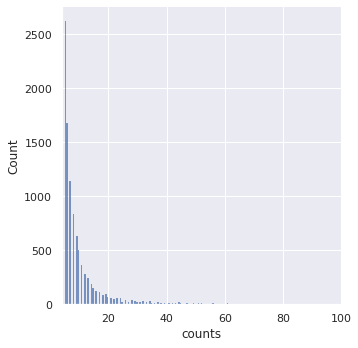

In [20]:
sns.displot(counts_sample.counts)
plt.xlim((4, 100))

In [22]:
user_counts.counts.quantile(0.95)

29.0

In [42]:
reviews_sample = reviews[
    reviews.reviewerID.isin(user_counts.reviewerID)
]

In [43]:
reviews_sample.shape

(3611487, 13)

Initially, for the life simulation, I thought we could use some period of time, like a couple of weeks. However, there are little interactions during that period, and I think is just a bit more convenient to simply select the last N interactions (N=50000) for that simulation

In [44]:
data_for_live_simulation = reviews_sample.sort_values('reviewDate')[-50000:]

In [45]:
reviews_sample = reviews_sample.sort_values('reviewDate')[:-50000]

In [46]:
data_for_live_simulation.reviewDate.min()

Timestamp('2018-03-22 00:00:00')

In [47]:
start_date = data_for_live_simulation.reviewDate.min() - pd.DateOffset(years=5)

In [48]:
start_date

Timestamp('2013-03-22 00:00:00')

We use 5 years of data to build a recommendation system

In [49]:
reviews_sample = reviews_sample[reviews_sample.reviewDate >= start_date]

In [50]:
reviews_sample.shape

(2618100, 13)

In [51]:
reviews_sample.reviewerID.nunique()

281549

Regarding to how one might split into train, valid and test, we could go a number of ways. We could split simply based on a timelime, which is probably what makes the most sense. Also, we could use the method followed when using the mult-VAE (splitting based on customers, rather than time) or in the neural cf paper (use the last interaction for testing and all the former for training). I need to think first on the system.

In [66]:
reviews_sample.count()/reviews_sample.shape[0]

overall           1.000000
verified          1.000000
reviewTime        1.000000
reviewerID        1.000000
asin              1.000000
style             0.957086
reviewerName      0.999974
reviewText        0.999409
summary           0.999809
unixReviewTime    1.000000
vote              0.091572
image             0.002032
reviewDate        1.000000
dtype: float64

we wull use all but vote and image

In [53]:
reviews_sample.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,reviewDate
2150792,5,True,"03 22, 2013",A1MHTXJA6IV1IY,B0002YLC1U,"{'Color:': None, 'Format:': ' DVD', 'Shape:': ...",comradeandlover,1930s Oklahoma is the setting for a stirring t...,Carnivale,1363910400,None,None,2013-03-22
2150791,5,True,"03 22, 2013",A3SGYEZJ6Y5KLR,B0002YLC1U,"{'Color:': None, 'Format:': ' DVD', 'Shape:': ...",L August Rockwell. Ill remember you forever,what can anyone say it is a DVD you have no ri...,VERY GOOD,1363910400,None,None,2013-03-22
2379327,5,False,"03 22, 2013",A2EL5RKNMZSMMF,B000A7S1TU,None,G-Man,This 2 DVD set is another great lesson from Ho...,Great for a beginner with helpful tips for an ...,1363910400,None,None,2013-03-22
5358932,1,False,"03 22, 2013",A2JJYM3Q1EF93U,B009OCR2U6,"{'Color:': None, 'Format:': ' Amazon Video', '...",Eddie L,The premise in this movie is not feasible. I d...,No way,1363910400,2,None,2013-03-22
4069308,3,True,"03 22, 2013",A1J46OZ55X3VBQ,B0034JKZ8G,"{'Color:': None, 'Format:': ' Blu-ray', 'Shape...",Amanda Willis,The dvd played perfectly until my daugher brok...,Princess & Frog,1363910400,None,None,2013-03-22


## Overall (stars)

In [54]:
reviews_sample.overall.value_counts()

5    1634902
4     478469
3     249823
1     136471
2     118435
Name: overall, dtype: int64

as we knew, most of them are 5. If we were for a multi categorical problem, I will map 1-2 into 0, 3 as 1 and 4-5 as 2

## Verified

In [55]:
reviews_sample.verified.value_counts()

True     2214563
False     403537
Name: verified, dtype: int64

binary, categorical feature

## reviewTime

Here we could build a number of behavioural features: most commin time of the day when they buy, most common day of the week or mean or median timediff between events 

## reviewerID

I will find the presentation where the guys at Catboost use users as a categorical feature (would be "equivalent" as using embeddings) but when using lightgbm/catboost, I intend to use it as cat feature and see what happens. 

## asin

Here we could build user features based on the products they buy, for example: most common category or min/max/mean/median price.

Also, same comment as before applies

## Style

In [58]:
reviews_sample['style'].sample(10)

147245     {'Color:': None, 'Format:': ' DVD', 'Shape:': ...
6702324    {'Color:': None, 'Format:': ' DVD', 'Shape:': ...
7874385    {'Color:': None, 'Format:': ' VHS Tape', 'Shap...
5166640    {'Color:': None, 'Format:': ' DVD', 'Shape:': ...
3676816    {'Color:': None, 'Format:': ' Amazon Video', '...
7207539    {'Color:': None, 'Format:': ' Prime Video', 'S...
4412042    {'Color:': None, 'Format:': ' Amazon Video', '...
7164917    {'Color:': None, 'Format:': ' DVD', 'Shape:': ...
77970      {'Color:': None, 'Format:': ' Blu-ray', 'Shape...
2786031    {'Color:': None, 'Format:': ' Amazon Video', '...
Name: style, dtype: object

In [59]:
def get_keys(x):
    try:
        return list(x.keys())
    except:
        return [] 

In [60]:
style_keys = reviews_sample['style'].apply(lambda x: get_keys(x))

In [61]:
style_keys[:10]

2150792    [Color:, Format:, Shape:, Size:]
2150791    [Color:, Format:, Shape:, Size:]
2379327                                  []
5358932    [Color:, Format:, Shape:, Size:]
4069308    [Color:, Format:, Shape:, Size:]
5333904    [Color:, Format:, Shape:, Size:]
1385285    [Color:, Format:, Shape:, Size:]
3077670    [Color:, Format:, Shape:, Size:]
3339470    [Color:, Format:, Shape:, Size:]
4968879    [Color:, Format:, Shape:, Size:]
Name: style, dtype: object

In [63]:
Counter([item for sublist in style_keys for item in sublist]).most_common(50)

[('Color:', 2505746),
 ('Format:', 2505746),
 ('Shape:', 2505746),
 ('Size:', 2505746)]

We ignore style

## reviewerName

we could infer gender using some python package (the same I used for the airbnb dataset)

## review Text and Summary

we could build a representation of a user based on these, but I am not sure is convenient, since basically, I do not think we would get useful information to build a recommendation system out of that representation, that we would not get from the remaining dataset